# Despliegue web utilizando Streamlit
- El objetivo sera crear un script utilizando streamlit para generar una web para predecir si un paciente tiene diabetes o no.
- Para ello utilizaré el modelo previamente entrenado en modulos anteriores de random forest, para la deteccion de diabetes.

### Carga datos


In [8]:
import pandas as pd
from xgboost import XGBClassifier

data = pd.read_csv('../data/raw/diabetes.csv')

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Los datos se tratan de un data set previamente trabajado, la finalidad de cargarlos en intentar mejorar el auc del random forest, para ello aplicare nuevas tecnicas aprendidas

Entrenando modelo xgboost
- Una mejora base es usar el modelo xgboost ya que al igual que randomforest es un modelo de arboles pero este tiene una particularidad, que mejora cada iteracion de forma sucesiva por lo que sus resultados tienden a ser mejores que decision tree y random forest.

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

### Evaluando rendimiento del modelo
- Al ser un problema de clasificación binaria nos interesa la metrica de valoracion AUC para ver la capacidad que tiene el modelo de separar las clases.
- También utilizaré el reporte de clasificacion, que ya incluye las metricas de precision, recall, f1-score.

In [10]:
from sklearn.metrics import auc, roc_auc_score, confusion_matrix, classification_report

auc = roc_auc_score(y_test, y_pred)
clasificacion_report = classification_report(y_test, y_pred)
print(f"AUC: {auc}")
print(clasificacion_report)

AUC: 0.7181818181818181
              precision    recall  f1-score   support

           0       0.82      0.73      0.77        99
           1       0.59      0.71      0.64        55

    accuracy                           0.72       154
   macro avg       0.70      0.72      0.71       154
weighted avg       0.74      0.72      0.73       154



### Mejorando el modelo
- Para ello utilizaré una busqueda de hiperparametros inteligente Optuna.
-

In [11]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

def objective(trial):

    # Definir el espacio de búsqueda de hiperparámetros
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }

    # Crear el clasificador XGBoost con los parámetros sugeridos
    model = xgb.XGBClassifier(**param)

    # Evaluar el modelo usando validación cruzada para obtener el AUC
    # Asegúrate de que X_train y y_train estén disponibles en el scope
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    # Devolver la media del AUC como el valor a maximizar
    return auc_scores.mean()

# 1. Crear un estudio de Optuna
# La dirección es 'maximize' porque queremos maximizar el AUC
study = optuna.create_study(direction='maximize')

# 2. Iniciar la optimización
# n_trials es el número de combinaciones de hiperparámetros a probar
study.optimize(objective, n_trials=30)

# 3. Imprimir los resultados
print("Número de trials finalizados: ", len(study.trials))
print("Mejores hiperparámetros encontrados: ", study.best_trial.params)
print("Mejor valor de AUC (validación cruzada): ", study.best_value)




C:\Users\Usuario\Documents\Git Hub Repositories\streamlit-app\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-30 00:36:04,901] A new study created in memory with name: no-name-5d38e89c-5857-4279-820f-556c6cd71385
[I 2025-11-30 00:36:08,413] Trial 0 finished with value: 0.8377029927675922 and parameters: {'n_estimators': 919, 'learning_rate': 0.2697106616906852, 'max_depth': 10, 'subsample': 0.8488393171020447, 'colsample_bytree': 0.5857136342940426, 'gamma': 3.074276005261691, 'min_child_weight': 7, 'reg_alpha': 0.05047636489295193, 'reg_lambda': 0.4282453302853547}. Best is trial 0 with value: 0.8377029927675922.
[I 2025-11-30 00:36:10,455] Trial 1 finished with value: 0.8375860984646515 and parameters: {'n_estimators': 959, 'learning_rate': 0.0903957632302424, 'max_depth': 7, 'subsample': 0.7850

Número de trials finalizados:  30
Mejores hiperparámetros encontrados:  {'n_estimators': 611, 'learning_rate': 0.19319966294258298, 'max_depth': 3, 'subsample': 0.978037212298472, 'colsample_bytree': 0.705569867925176, 'gamma': 4.343610029280109, 'min_child_weight': 1, 'reg_alpha': 0.9405004555486347, 'reg_lambda': 0.1790857710566826}
Mejor valor de AUC (validación cruzada):  0.8469163402512885


Entrenar el modelo final con los mejores hiperparámetros

In [12]:

best_params = study.best_trial.params
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.705569867925176
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [13]:
y_pred = final_model.predict(X_test)
auc_test = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
print(f"AUC en el conjunto de prueba: {auc_test}")

AUC en el conjunto de prueba: 0.8248852157943067


### ROC CURVE
- roc_curve devuelve: Tasa de Falsos Positivos (fpr), Tasa de Verdaderos Positivos (tpr) y umbrales
- Es la representacion visual del area bajo la curva AUC, el rendimiento fue 82%, mucho mejor comparado con el modelo base 71%

El AUC en el conjunto de prueba es: 0.8249


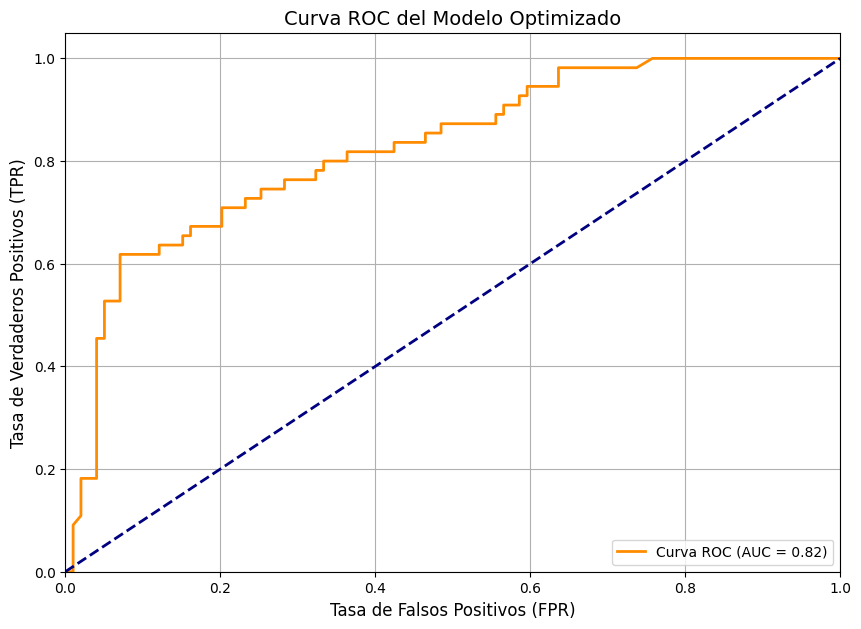

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Calcular el área bajo la curva (AUC)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"El AUC en el conjunto de prueba es: {auc_score:.4f}")

# Graficar la curva ROC
plt.figure(figsize=(10, 7))

# Dibuja la curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curva ROC del Modelo Optimizado', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)

# Muestra el gráfico
plt.show()

### Guardado de modelo final para produccion de streamlit
- Ahora si, el despliegue de la app web de nuestro modelo es mas robusto para distinguir las clases, ahora procederé a guardar el modelo para implementarlo.
-

In [ ]:
import pickle

pickle.dump(final_model, open('../models/best_model.pkl', 'wb'))